# **REINFORCEMENT LEARNING FOR PORTFOLIO OPTIMISATION**
----


#### 1.1 Data Preparation

The input data consists of monthly returns ($R_{it}$) for 5 industrial stocks, starting from the first column as the date. The returns are normalized by dividing by 100 for calculation purposes. The data is split into three sets:
- Training Set: $\text{Year} \leq 2010$
- Validation Set: $ 2010 < \text{Year} \leq 2015 $
- Test Set: $ \text{Year} > 2015 $

#### 1.2 Lookback Period

A lookback period ($L$) of 3 months is used to observe past returns for decision-making in the current step.

### 2. Portfolio Optimization Process

#### 2.1 Portfolio Allocation Initialization

The portfolio allocation vector ($\mathbf{w}$) is initialized to equal weights for all assets:
$$ \mathbf{w}_t = \frac{1}{N} $$
where $N$ is the number of assets.

#### 2.2 Action and Observation Spaces

- **Action Space**: Represents portfolio weights ($\mathbf{w}_t$) bounded between 0 and 1.
- **Observation Space**: Combines returns for the lookback period and current portfolio allocation.
$$\mathbf{S}_t = \left[ \begin{array}{cccc}
r_{1,t-3} & r_{1,t-2} & r_{1,t-1} & w_{1,t} \\
r_{2,t-3} & r_{2,t-2} & r_{2,t-1} & w_{2,t} \\
r_{3,t-3} & r_{3,t-2} & r_{3,t-1} & w_{3,t} \\
r_{4,t-3} & r_{4,t-2} & r_{4,t-1} & w_{4,t} \\
r_{5,t-3} & r_{5,t-2} & r_{5,t-1} & w_{5,t}
\end{array} \right]$$
#### 2.3 Differential Sharpe Ratio Calculation

To evaluate the performance, the Differential Sharpe Ratio ($\text{DSR}_t $) is utilized, which depends on the mean and variance of portfolio returns over time.

- **Variables**:
  - $A_t$: Adjusted mean return
  - $B_t$: Adjusted variance return
  - $\eta$: Adjustment parameter, set to $\frac{1}{12}$

- **Updates**:
  $$\Delta A_t = r_t - A_t$$
  $$\Delta B_t = r_t^2 - B_t$$
  $$A_t = A_t + \eta \Delta A_t$$
  $$B_t = B_t + \eta \Delta B_t$$

- **Reward Calculation**:
  $$
  \text{Reward}_t = \frac{B_t \Delta A_t - 0.5 A_t \Delta B_t}{(B_t - A_t^2)^{3/2}}
  $$

#### 2.4 Portfolio Return Calculation

Portfolio return ($r_t$) at time $t$ is calculated as:
$$ r_t = \mathbf{w}_t \cdot R_t $$
where $R_t$ is the return vector at time $t$.

### 3. Model Training and Validation

#### 3.1 Proximal Policy Optimization (PPO)

The PPO algorithm is used for training the agent, which optimizes portfolio allocation to maximize the cumulative reward.

- **Hyperparameters**:
  $$
  \begin{align*}
  \text{Learning Rate} &= 3 \times 10^{-4} \\
  \text{n\_steps} &= 7560 \\
  \text{Batch Size} &= 1260 \\
  \text{n\_epochs} &= 100 \\
  \gamma &= 0.9 \\
  \lambda &= 0.9 \\
  \text{Clip Range} &= 0.25
  \end{align*}
  $$

#### 3.2 Training Process

The model is trained over 50 epochs with early stopping based on validation performance to avoid overfitting. Training and validation rewards are monitored for each epoch.

### 4. Model Evaluation

#### 4.1 Evaluation Function

The evaluation function assesses the model performance on the test set, starting with an initial investment ($$I_0 = 1,000,000$$) USD. The portfolio return and fund value ($$V_t$$) at each step are calculated as:
$$ V_{t+1} = V_t \times (1 + r_t) $$

#### 4.2 Results and Plots

- **Training Cumulative Rewards and Fund Value**
- **Validation Cumulative Rewards and Fund Value**
- **Test Cumulative Rewards and Fund Value**

These metrics are plotted to visualize the model's performance over time for the training, validation, and test sets.

### Conclusion

The PPO-based portfolio optimization effectively balances the returns across multiple industrial stocks, considering past performance and risk-adjusted rewards. The cumulative rewards and fund values provide insights into the model's ability to generate consistent and optimized returns.



In [ ]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# Custom environment for portfolio optimization
class PortfolioEnv(gym.Env):
    def __init__(self, returns, dates, lookback_period=12):
        super(PortfolioEnv, self).__init__()

        self.returns = returns
        self.dates = dates
        self.lookback_period = lookback_period
        self.num_assets = returns.shape[1]
        self.current_step = lookback_period

        # Action space: portfolio weights
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_assets,), dtype=np.float32)

        # Observation space: lookback period of log returns + current portfolio allocation
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.num_assets, lookback_period + 1), dtype=np.float32)

        # Initialize portfolio allocation
        self.portfolio_allocation = np.ones(self.num_assets) / self.num_assets  # Start with equal weights

        # Initialize variables for Differential Sharpe Ratio
        self.A_t = 0
        self.B_t = 0
        self.eta = 1 / 12

    def reset(self):
        self.current_step = self.lookback_period
        self.A_t = 0
        self.B_t = 0
        self.portfolio_allocation = np.ones(self.num_assets) / self.num_assets  # Reset to equal weights
        return self._next_observation()

    def _next_observation(self):
        lookback_returns = self.returns[self.current_step - self.lookback_period:self.current_step]

        # Reshape portfolio allocation to be consistent with lookback_returns
        portfolio_allocation_column = self.portfolio_allocation.reshape(-1, 1)

        # Combine lookback_returns and portfolio_allocation_matrix
        obs = np.hstack((lookback_returns.T, portfolio_allocation_column))

        # Debugging: Print the shape and values of obs
        assert obs.shape == (self.num_assets, self.lookback_period + 1), f"Observation shape mismatch: {obs.shape}"
        if np.any(np.isnan(obs)):
            print("NaN values found in observations:")
            print(obs)
            raise ValueError("NaN values found in observations")

        return obs

    def step(self, action):
        self.current_step += 1

        # Clip action values to avoid very small values
        action = np.clip(action, 1e-6, 1)

        # Check if action sum is zero or very close to zero to avoid NaN values
        action_sum = np.sum(action)
        if action_sum == 0 or np.isclose(action_sum, 0):
            print(f"Action: {action}")
            print(f"Action sum: {action_sum}")
            raise ValueError("Action sum is zero or too close to zero, cannot normalize weights.")

        # Normalize the action
        self.portfolio_allocation = action / action_sum

        # Check for NaN values after normalization
        if np.any(np.isnan(self.portfolio_allocation)):
            print("NaN values found in portfolio allocation after normalization:")
            print(f"Action: {action}, Sum: {action_sum}")
            raise ValueError("NaN values found in portfolio allocation after normalization.")

        portfolio_return = np.dot(self.portfolio_allocation, self.returns[self.current_step])

        delta_A_t = portfolio_return - self.A_t
        delta_B_t = portfolio_return**2 - self.B_t

        self.A_t += self.eta * delta_A_t
        self.B_t += self.eta * delta_B_t

        # Prevent division by zero or invalid reward calculations
        denom = (self.B_t - self.A_t**2)**(3/2)
        if denom == 0:
            reward = 0
        else:
            reward = (self.B_t * delta_A_t - 0.5 * self.A_t * delta_B_t) / denom

        reward = np.nan_to_num(reward)  # Handle any NaNs

        obs = self._next_observation()
        done = self.current_step >= len(self.returns) - 1

        # Debugging: Print the reward and check for NaNs
        if np.isnan(reward):
            print("NaN value found in reward calculation")
            print(f"portfolio_return: {portfolio_return}, delta_A_t: {delta_A_t}, delta_B_t: {delta_B_t}, denom: {denom}")
            raise ValueError("NaN value found in reward")

        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        pass


# Load data
file_path = r'C:\Users\mandu\Desktop\VM\5_Industry_Portfolios.CSV'
df = pd.read_csv(file_path, index_col=0, header=0, parse_dates=True)
df.index = pd.to_datetime(df.index, format='%Y%m')  # Adjust date format as needed

df = df / 100

# Split the dataset by dates (assuming your index is already a datetime object)
train_data = df[df.index.year <= 2010]
valid_data = df[(df.index.year > 2010) & (df.index.year <= 2015)]
test_data = df[df.index.year > 2015]

train_returns = train_data.values
valid_returns = valid_data.values
test_returns = test_data.values

train_dates = train_data.index.values
valid_dates = valid_data.index.values
test_dates = test_data.index.values

# Create training, validation, and test environments
train_env = DummyVecEnv([lambda: PortfolioEnv(train_returns, train_dates)])
valid_env = DummyVecEnv([lambda: PortfolioEnv(valid_returns, valid_dates)])
test_env = DummyVecEnv([lambda: PortfolioEnv(test_returns, test_dates)])

def evaluate_model(env, returns, dates, model, initial_investment=1000000):
    current_fund = initial_investment
    obs = env.reset()
    cumulative_rewards = []
    fund_values = [current_fund]
    weights = []

    for i in range(len(returns) - env.envs[0].lookback_period):
        action, _states = model.predict(obs)

        # Normalize the action to make sure the weights sum to 1
        action_sum = np.sum(action)
        if action_sum != 0:
            action = action / action_sum

        obs, rewards, done, info = env.step(action)
        if done:
            break

        # Ensure portfolio_return is a scalar
        portfolio_return = np.dot(action, returns[env.envs[0].current_step])
        if isinstance(portfolio_return, np.ndarray):
            portfolio_return = portfolio_return.item()

        # Update the fund value based on the portfolio return
        current_fund *= (1 + portfolio_return)

        # Save the weights and corresponding date
        weight_record = {'Date': dates[env.envs[0].current_step]}
        for idx, col in enumerate(df.columns):
            weight_record[col] = action[idx]
        weights.append(weight_record)

        # Accumulate the rewards and fund values
        cumulative_rewards.append(rewards)
        fund_values.append(current_fund)

    # Convert list of cumulative rewards, fund values, and weights to numpy arrays for plotting
    cumulative_rewards = np.array(cumulative_rewards)
    fund_values = np.array(fund_values, dtype=np.float64)

    return cumulative_rewards, fund_values, weights

# Define hyperparameters for PPO
hyperparams = {
    'learning_rate': 3e-4,
    'n_steps': 7560,
    'batch_size': 1260,
    'n_epochs': 100,
    'gamma': 0.9,
    'gae_lambda': 0.9,
    'clip_range': 0.25
}

# Initialize the PPO model (agent) with the environment
model = PPO('MlpPolicy', train_env, verbose=1, **hyperparams)

# Train the agent and evaluate on the validation set with early stopping
train_rewards = []
valid_rewards = []
num_epochs = 50
patience = 10
best_valid_reward = -np.inf
patience_counter = 0

for epoch in range(num_epochs):
    model.learn(total_timesteps=2048, reset_num_timesteps=False)

    # Evaluate on training set
    obs = train_env.reset()
    train_cumulative_reward = 0
    while True:
        action, _states = model.predict(obs)
        obs, rewards, done, _ = train_env.step(action)
        train_cumulative_reward += rewards[0]
        if done:
            break
    train_rewards.append(train_cumulative_reward)

    # Evaluate on validation set
    obs = valid_env.reset()
    valid_cumulative_reward = 0
    while True:
        action, _states = model.predict(obs)
        obs, rewards, done, _ = valid_env.step(action)
        valid_cumulative_reward += rewards[0]
        if done:
            break
    valid_rewards.append(valid_cumulative_reward)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Reward: {train_cumulative_reward}, Valid Reward: {valid_cumulative_reward}")

    # Early stopping check
    if valid_cumulative_reward > best_valid_reward:
        best_valid_reward = valid_cumulative_reward
        patience_counter = 0
        # Save the best model
        model.save("best_model.zip")
        print("Best model saved")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation rewards
plt.plot(train_rewards, label='Training Reward')
plt.plot(valid_rewards, label='Validation Reward')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.title('Training vs Validation Reward')
plt.show()

# Load the best model for further use
best_model = PPO.load("best_model.zip")


# Define a function to evaluate the model on a given environment
def evaluate_model(env, returns, initial_investment=1000000):
    current_fund = initial_investment
    obs = env.reset()
    cumulative_rewards = []
    fund_values = [current_fund]
    portfolio_returns = []

    for _ in range(len(returns) - env.envs[0].lookback_period):
        action, _states = model.predict(obs)

        # Normalize the action to make sure the weights sum to 1
        action_sum = np.sum(action)
        if action_sum != 0:
            action = action / action_sum

        obs, rewards, done, info = env.step(action)
        if done:
            break

        # Ensure portfolio_return is a scalar
        portfolio_return = np.dot(action, returns[env.envs[0].current_step])
        if isinstance(portfolio_return, np.ndarray):
            portfolio_return = portfolio_return.item()

        # Update the fund value based on the portfolio return
        current_fund *= (1 + portfolio_return)

        # Print the portfolio weights (action), portfolio return, reward, and fund value at each step
        print(f"Portfolio Weights: {action}, Portfolio Return: {portfolio_return}, Reward: {rewards}, Fund Value: {current_fund}")

        # Accumulate the portfolio returns, rewards, and fund values
        portfolio_returns.append(portfolio_return)
        cumulative_rewards.append(rewards)
        fund_values.append(current_fund)

    # Convert lists to numpy arrays for plotting
    cumulative_rewards = np.array(cumulative_rewards)
    fund_values = np.array(fund_values, dtype=np.float64)
    portfolio_returns = np.array(portfolio_returns, dtype=np.float64)

    return portfolio_returns, cumulative_rewards, fund_values

# Evaluate the model on the training set
print("Evaluating on Training Set")
train_portfolio_returns, train_cumulative_rewards, train_fund_values = evaluate_model(train_env, train_returns)

# Evaluate the model on the validation set
print("Evaluating on Validation Set")
valid_portfolio_returns, valid_cumulative_rewards, valid_fund_values = evaluate_model(valid_env, valid_returns)

# Evaluate the model on the test set
print("Evaluating on Test Set")
test_portfolio_returns, test_cumulative_rewards, test_fund_values = evaluate_model(test_env, test_returns)

# Plot the cumulative returns, fund values, and portfolio returns for training, validation, and test sets
plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
train_cumulative_returns = np.cumsum(train_cumulative_rewards)
plt.plot(train_cumulative_returns, label='Train Cumulative Rewards')
plt.title('Train Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Rewards')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_fund_values, label='Train Fund Value')
plt.title('Train Fund Value Over Time')
plt.xlabel('Time')
plt.ylabel('Fund Value (USD)')
plt.legend()

plt.subplot(3, 2, 3)
valid_cumulative_returns = np.cumsum(valid_cumulative_rewards)
plt.plot(valid_cumulative_returns, label='Valid Cumulative Rewards')
plt.title('Valid Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Rewards')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(valid_fund_values, label='Valid Fund Value')
plt.title('Valid Fund Value Over Time')
plt.xlabel('Time')
plt.ylabel('Fund Value (USD)')
plt.legend()

plt.subplot(3, 2, 5)
test_cumulative_returns = np.cumsum(test_cumulative_rewards)
plt.plot(test_cumulative_returns, label='Test Cumulative Rewards')
plt.title('Test Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Rewards')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(test_fund_values, label='Test Fund Value')
plt.title('Test Fund Value Over Time')
plt.xlabel('Time')
plt.ylabel('Fund Value (USD)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot portfolio returns for training, validation, and test sets
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(train_portfolio_returns, label='Train Portfolio Returns')
plt.title('Train Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(valid_portfolio_returns, label='Valid Portfolio Returns')
plt.title('Valid Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_portfolio_returns, label='Test Portfolio Returns')
plt.title('Test Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.legend()

plt.tight_layout()
plt.show()


import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming test_portfolio_returns is the numpy array with monthly returns
# Convert monthly returns to a Pandas Series for easier handling
monthly_returns = pd.Series(test_portfolio_returns)

# Calculate annual return
annual_return = ((1 + monthly_returns).prod() ** (12 / len(monthly_returns)) - 1)

# Calculate cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod() - 1

# Calculate annual volatility
annual_volatility = monthly_returns.std() * np.sqrt(12)

# Calculate Sharpe ratio
risk_free_rate = 0.02  # Assume a risk-free rate of 2%
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

# Calculate maximum drawdown
cumulative = (1 + monthly_returns).cumprod()
drawdown = 1 - cumulative / cumulative.cummax()
max_drawdown = drawdown.max()

# Calculate Calmar ratio
calmar_ratio = annual_return / max_drawdown

# Calculate Omega ratio
threshold_return = 0
gain_threshold = monthly_returns[monthly_returns > threshold_return].sum()
loss_threshold = -monthly_returns[monthly_returns < threshold_return].sum()
omega_ratio = gain_threshold / loss_threshold

# Calculate Sortino ratio
downside_deviation = monthly_returns[monthly_returns < 0].std() * np.sqrt(12)
sortino_ratio = (annual_return - risk_free_rate) / downside_deviation

# Calculate skewness
returns_skewness = skew(monthly_returns)

# Calculate kurtosis
returns_kurtosis = kurtosis(monthly_returns)

# Calculate the tail ratio
tail_ratio = monthly_returns[monthly_returns > monthly_returns.quantile(0.95)].mean() / abs(monthly_returns[monthly_returns < monthly_returns.quantile(0.05)].mean())

# Calculate daily value at risk (VaR)
confidence_level = 0.05
var_95 = np.percentile(monthly_returns, 100 * confidence_level)

# Compile results into a DataFrame
performance_metrics = {
    "Annual Return": [annual_return],
    "Cumulative Returns": [cumulative_returns.iloc[-1]],
    "Annual Volatility": [annual_volatility],
    "Sharpe Ratio": [sharpe_ratio],
    "Calmar Ratio": [calmar_ratio],
    "Max Drawdown": [max_drawdown],
    "Omega Ratio": [omega_ratio],
    "Sortino Ratio": [sortino_ratio],
    "Skew": [returns_skewness],
    "Kurtosis": [returns_kurtosis],
    "Tail Ratio": [tail_ratio],
    "Daily Value at Risk (VaR 95%)": [var_95]
}

performance_df = pd.DataFrame(performance_metrics)

# Display the performance metrics table
performance_df


from stable_baselines3 import DDPG, TD3, SAC, A2C
from stable_baselines3.common.noise import NormalActionNoise

# Define hyperparameters
ddpg_hyperparams = {
    'learning_rate': 3e-4,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99
}

td3_hyperparams = {
    'learning_rate': 3e-4,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99
}

sac_hyperparams = {
    'learning_rate': 3e-4,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99
}

a2c_hyperparams = {
    'learning_rate': 3e-4,
    'n_steps': 5,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'ent_coef': 0.0,
    'vf_coef': 0.5,
    'max_grad_norm': 0.5
}

# Initialize the models
models = {
    'DDPG': DDPG('MlpPolicy', train_env, verbose=1, **ddpg_hyperparams),
    'TD3': TD3('MlpPolicy', train_env, verbose=1, **td3_hyperparams),
    'SAC': SAC('MlpPolicy', train_env, verbose=1, **sac_hyperparams),
    'A2C': A2C('MlpPolicy', train_env, verbose=1, **a2c_hyperparams)
}

# Train the models with early stopping
num_epochs = 50
patience = 10

for model_name, model in models.items():
    print(f"Training {model_name}")
    train_rewards = []
    valid_rewards = []
    best_valid_reward = -np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        model.learn(total_timesteps=1014, reset_num_timesteps=False)

        # Evaluate on training set
        obs = train_env.reset()
        train_cumulative_reward = 0
        while True:
            action, _states = model.predict(obs)
            obs, rewards, done, _ = train_env.step(action)
            train_cumulative_reward += rewards[0]
            if done:
                break
        train_rewards.append(train_cumulative_reward)

        # Evaluate on validation set
        obs = valid_env.reset()
        valid_cumulative_reward = 0
        while True:
            action, _states = model.predict(obs)
            obs, rewards, done, _ = valid_env.step(action)
            valid_cumulative_reward += rewards[0]
            if done:
                break
        valid_rewards.append(valid_cumulative_reward)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Reward: {train_cumulative_reward}, Valid Reward: {valid_cumulative_reward}")

        # Early stopping check
        if valid_cumulative_reward > best_valid_reward:
            best_valid_reward = valid_cumulative_reward
            patience_counter = 0
            # Save the best model
            model.save(f"best_model_{model_name}.zip")
            print(f"Best model for {model_name} saved")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered for {model_name}")
                break

    # Plot the training and validation rewards
    plt.plot(train_rewards, label=f'{model_name} Training Reward')
    plt.plot(valid_rewards, label=f'{model_name} Validation Reward')
    plt.xlabel('Epochs')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.title(f'{model_name} Training vs Validation Reward')
    plt.show()

# Load the best models for further use
best_models = {model_name: model.load(f"best_model_{model_name}.zip") for model_name, model in models.items()}

# Evaluate models and collect results
results = {}

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}")
    test_portfolio_returns, test_cumulative_rewards, test_fund_values = evaluate_model(test_env, test_returns, initial_investment=1000000)
    
    # Calculate performance metrics
    monthly_returns = pd.Series(test_portfolio_returns)
    annual_return = ((1 + monthly_returns).prod() ** (12 / len(monthly_returns)) - 1)
    cumulative_returns = (1 + monthly_returns).cumprod() - 1
    annual_volatility = monthly_returns.std() * np.sqrt(12)
    risk_free_rate = 0.02
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    cumulative = (1 + monthly_returns).cumprod()
    drawdown = 1 - cumulative / cumulative.cummax()
    max_drawdown = drawdown.max()
    calmar_ratio = annual_return / max_drawdown
    threshold_return = 0
    gain_threshold = monthly_returns[monthly_returns > threshold_return].sum()
    loss_threshold = -monthly_returns[monthly_returns < threshold_return].sum()
    omega_ratio = gain_threshold / loss_threshold
    downside_deviation = monthly_returns[monthly_returns < 0].std() * np.sqrt(12)
    sortino_ratio = (annual_return - risk_free_rate) / downside_deviation
    returns_skewness = skew(monthly_returns)
    returns_kurtosis = kurtosis(monthly_returns)
    tail_ratio = monthly_returns.quantile(0.95) / abs(monthly_returns.quantile(0.05))
    confidence_level = 0.05
    var_95 = np.percentile(monthly_returns, 100 * confidence_level)

    performance_metrics = {
        "Annual Return": annual_return,
        "Cumulative Returns": cumulative_returns.iloc[-1],
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Calmar Ratio": calmar_ratio,
        "Max Drawdown": max_drawdown,
        "Omega Ratio": omega_ratio,
        "Sortino Ratio": sortino_ratio,
        "Skew": returns_skewness,
        "Kurtosis": returns_kurtosis,
        "Tail Ratio": tail_ratio,
        "Daily Value at Risk (VaR 95%)": var_95
    }

    results[model_name] = performance_metrics

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

performance_df.index = ['PPO']

# Combine performance_df with results_df
combined_results_df = pd.concat([performance_df, results_df])
combined_results_df

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

# Assuming test_data is already loaded
# Calculate the portfolio returns by equally weighting each stock
portfolio_returns = test_data.mean(axis=1)

# Calculate performance metrics
# Convert monthly returns to a Pandas Series for easier handling
monthly_returns = pd.Series(portfolio_returns)

# Calculate annual return
annual_return_1_n = ((1 + monthly_returns).prod() ** (12 / len(monthly_returns)) - 1)

# Calculate cumulative returns
cumulative_returns_1_n = (1 + monthly_returns).cumprod() - 1

# Calculate annual volatility
annual_volatility_1_n = monthly_returns.std() * np.sqrt(12)

# Calculate Sharpe ratio
risk_free_rate = 0.02  # Assume a risk-free rate of 2%
sharpe_ratio_1_n = (annual_return_1_n - risk_free_rate) / annual_volatility_1_n

# Calculate maximum drawdown
cumulative = (1 + monthly_returns).cumprod()
drawdown = 1 - cumulative / cumulative.cummax()
max_drawdown_1_n = drawdown.max()

# Calculate Calmar ratio
calmar_ratio_1_n = annual_return_1_n / max_drawdown_1_n

# Calculate Omega ratio
threshold_return = 0
gain_threshold = monthly_returns[monthly_returns > threshold_return].sum()
loss_threshold = -monthly_returns[monthly_returns < threshold_return].sum()
omega_ratio_1_n = gain_threshold / loss_threshold

# Calculate Sortino ratio
downside_deviation = monthly_returns[monthly_returns < 0].std() * np.sqrt(12)
sortino_ratio_1_n = (annual_return_1_n - risk_free_rate) / downside_deviation

# Calculate skewness
skew_1_n = skew(monthly_returns)

# Calculate kurtosis
kurtosis_1_n = kurtosis(monthly_returns)

# Calculate tail ratio
tail_ratio_1_n = monthly_returns.quantile(0.95) / abs(monthly_returns.quantile(0.05))

# Calculate daily value at risk (VaR)
confidence_level = 0.05
var_95_1_n = np.percentile(monthly_returns, 100 * confidence_level)

# Compile results into a DataFrame
performance_metrics_equal = {
    "Annual Return": [annual_return_1_n],
    "Cumulative Returns": [cumulative_returns_1_n.iloc[-1]],
    "Annual Volatility": [annual_volatility_1_n],
    "Sharpe Ratio": [sharpe_ratio_1_n],
    "Calmar Ratio": [calmar_ratio_1_n],
    "Max Drawdown": [max_drawdown_1_n],
    "Omega Ratio": [omega_ratio_1_n],
    "Sortino Ratio": [sortino_ratio_1_n],
    "Skew": [skew_1_n],
    "Kurtosis": [kurtosis_1_n],
    "Tail Ratio": [tail_ratio_1_n],
    "Daily Value at Risk (VaR 95%)": [var_95_1_n]
}

performance_df_equal = pd.DataFrame(performance_metrics_equal, index=['Equal_Weight'])

# Display the performance metrics table
performance_df_equal

# Combine performance_df with results_df
combined_results_df = pd.concat([combined_results_df, performance_df_equal])
combined_results_df


## **1. Import Libraries**

In [5]:
import numpy as np
import torch
import gym
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO, DDPG, TD3, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import pandas as pd
from gym import spaces


In [6]:
# Set the random seed for reproducibility
def set_global_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    set_random_seed(seed)

seed = 42
set_global_seed(seed)

---

## **2. Define Custom Environment for Portfolio Optimization**

In [7]:
# Custom environment for portfolio optimization
class PortfolioEnv(gym.Env):
    def __init__(self, returns, dates, lookback_period=12):
        super(PortfolioEnv, self).__init__()

        self.returns = returns
        self.dates = dates
        self.lookback_period = lookback_period
        self.num_assets = returns.shape[1]
        self.current_step = lookback_period

        # Action space: portfolio weights
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_assets,), dtype=np.float32)

        # Observation space: lookback period of log returns + current portfolio allocation
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.num_assets, lookback_period + 1), dtype=np.float32)

        # Initialize portfolio allocation
        self.portfolio_allocation = np.ones(self.num_assets) / self.num_assets  # Start with equal weights

        # Initialize variables for Differential Sharpe Ratio
        self.A_t = 0
        self.B_t = 0
        self.eta = 1 / 12

    def reset(self):
        self.current_step = self.lookback_period
        self.A_t = 0
        self.B_t = 0
        self.portfolio_allocation = np.ones(self.num_assets) / self.num_assets  # Reset to equal weights
        return self._next_observation()

    def _next_observation(self):
        lookback_returns = self.returns[self.current_step - self.lookback_period:self.current_step]

        # Reshape portfolio allocation to be consistent with lookback_returns
        portfolio_allocation_column = self.portfolio_allocation.reshape(-1, 1)

        # Combine lookback_returns and portfolio_allocation_matrix
        obs = np.hstack((lookback_returns.T, portfolio_allocation_column))

        # Debugging: Print the shape and values of obs
        assert obs.shape == (self.num_assets, self.lookback_period + 1), f"Observation shape mismatch: {obs.shape}"
        if np.any(np.isnan(obs)):
            print("NaN values found in observations:")
            print(obs)
            raise ValueError("NaN values found in observations")

        return obs

    def step(self, action):
        self.current_step += 1

        # Clip action values to avoid very small values
        action = np.clip(action, 1e-6, 1)

        # Check if action sum is zero or very close to zero to avoid NaN values
        action_sum = np.sum(action)
        if action_sum == 0 or np.isclose(action_sum, 0):
            print(f"Action: {action}")
            print(f"Action sum: {action_sum}")
            raise ValueError("Action sum is zero or too close to zero, cannot normalize weights.")

        # Normalize the action
        self.portfolio_allocation = action / action_sum

        # Check for NaN values after normalization
        if np.any(np.isnan(self.portfolio_allocation)):
            print("NaN values found in portfolio allocation after normalization:")
            print(f"Action: {action}, Sum: {action_sum}")
            raise ValueError("NaN values found in portfolio allocation after normalization.")

        portfolio_return = np.dot(self.portfolio_allocation, self.returns[self.current_step])

        delta_A_t = portfolio_return - self.A_t
        delta_B_t = portfolio_return**2 - self.B_t

        self.A_t += self.eta * delta_A_t
        self.B_t += self.eta * delta_B_t

        # Prevent division by zero or invalid reward calculations
        denom = (self.B_t - self.A_t**2)**(3/2)
        if denom == 0:
            reward = 0
        else:
            reward = (self.B_t * delta_A_t - 0.5 * self.A_t * delta_B_t) / denom

        reward = np.nan_to_num(reward)  # Handle any NaNs

        obs = self._next_observation()
        done = self.current_step >= len(self.returns) - 1

        # Debugging: Print the reward and check for NaNs
        if np.isnan(reward):
            print("NaN value found in reward calculation")
            print(f"portfolio_return: {portfolio_return}, delta_A_t: {delta_A_t}, delta_B_t: {delta_B_t}, denom: {denom}")
            raise ValueError("NaN value found in reward")

        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        pass


## **3. Load Data and Create Environments**

In [8]:
# Load data
file_path = r'C:\Users\mandu\Desktop\VM\5_Industry_Portfolios.CSV'
df = pd.read_csv(file_path, index_col=0, header=0, parse_dates=True)
df.index = pd.to_datetime(df.index, format='%Y%m')  # Adjust date format as needed

df = df / 100

# Split the dataset by dates (assuming your index is already a datetime object)
train_data = df[df.index.year <= 2010]
valid_data = df[(df.index.year > 2010) & (df.index.year <= 2015)]
test_data = df[df.index.year > 2015]

train_returns = train_data.values
valid_returns = valid_data.values
test_returns = test_data.values

train_dates = train_data.index.values
valid_dates = valid_data.index.values
test_dates = test_data.index.values

# Create training, validation, and test environments
train_env = DummyVecEnv([lambda: PortfolioEnv(train_returns, train_dates)])
valid_env = DummyVecEnv([lambda: PortfolioEnv(valid_returns, valid_dates)])
test_env = DummyVecEnv([lambda: PortfolioEnv(test_returns, test_dates)])


C:\Users\mandu\AppData\Local\Temp\ipykernel_12876\898037376.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, header=0, parse_dates=True)
c:\Users\mandu\anaconda3\envs\MASTER-THESIS-VM\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## **4. Define Evaluation Function to Save Weights with Dates**

In [9]:
def evaluate_model(env, returns, dates, model, initial_investment=1000000):
    current_fund = initial_investment
    obs = env.reset()
    cumulative_rewards = []
    fund_values = [current_fund]
    weights = []

    for i in range(len(returns) - env.envs[0].lookback_period):
        action, _states = model.predict(obs)

        # Normalize the action to make sure the weights sum to 1
        action_sum = np.sum(action)
        if action_sum != 0:
            action = action / action_sum

        obs, rewards, done, info = env.step(action)
        if done:
            break

        # Ensure portfolio_return is a scalar
        portfolio_return = np.dot(action, returns[env.envs[0].current_step])
        if isinstance(portfolio_return, np.ndarray):
            portfolio_return = portfolio_return.item()

        # Update the fund value based on the portfolio return
        current_fund *= (1 + portfolio_return)

        # Save the weights and corresponding date
        weight_record = {'Date': dates[env.envs[0].current_step]}
        for idx, col in enumerate(df.columns):
            weight_record[col] = action[idx]
        weights.append(weight_record)

        # Accumulate the rewards and fund values
        cumulative_rewards.append(rewards)
        fund_values.append(current_fund)

    # Convert list of cumulative rewards, fund values, and weights to numpy arrays for plotting
    cumulative_rewards = np.array(cumulative_rewards)
    fund_values = np.array(fund_values, dtype=np.float64)

    return cumulative_rewards, fund_values, weights


## **5. Train and Evaluate the Model**

Using cpu device


c:\Users\mandu\anaconda3\envs\MASTER-THESIS-VM\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1014`, after every 3 untruncated mini-batches, there will be a truncated mini-batch of size 246
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1014 and n_envs=1)
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 989  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1014 |
-----------------------------
Epoch 1/50, Train Reward: 32.63141774642281, Valid Reward: 2.9181239381432533
Best model saved
-----------------------------
| time/              |      |
|    fps             | 957  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2028 |
-----------------------------
Epoch 2/50, Train Reward: 28.970655014330987, Valid Reward: 2.304903268814087
-----------------------------
| time/              |      |
|    fps             | 1448 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 3042 |
-----------------------------
Epoch 3/50, Train Reward: 31.730213739036117, Valid Reward: 4.644060164690018
Best model saved
-----------------------------
| time/              |      |
|    fps             | 1412 |
|    iterati

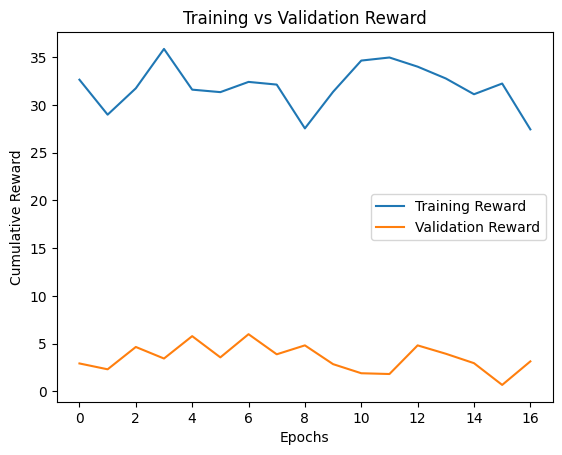

In [10]:
# Define hyperparameters for PPO
hyperparams = {
    'learning_rate': 3e-4,
    'n_steps': 1014,
    'batch_size': 256,
    'n_epochs': 100,
    'gamma': 0.9,
    'gae_lambda': 0.9,
    'clip_range': 0.25
}

# Initialize the PPO model (agent) with the environment
model = PPO('MlpPolicy', train_env, verbose=1, **hyperparams)

# Train the agent and evaluate on the validation set with early stopping
train_rewards = []
valid_rewards = []
num_epochs = 50
patience = 10
best_valid_reward = -np.inf
patience_counter = 0

for epoch in range(num_epochs):
    model.learn(total_timesteps=1014, reset_num_timesteps=False)

    # Evaluate on training set
    obs = train_env.reset()
    train_cumulative_reward = 0
    while True:
        action, _states = model.predict(obs)
        obs, rewards, done, _ = train_env.step(action)
        train_cumulative_reward += rewards[0]
        if done:
            break
    train_rewards.append(train_cumulative_reward)

    # Evaluate on validation set
    obs = valid_env.reset()
    valid_cumulative_reward = 0
    while True:
        action, _states = model.predict(obs)
        obs, rewards, done, _ = valid_env.step(action)
        valid_cumulative_reward += rewards[0]
        if done:
            break
    valid_rewards.append(valid_cumulative_reward)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Reward: {train_cumulative_reward}, Valid Reward: {valid_cumulative_reward}")

    # Early stopping check
    if valid_cumulative_reward > best_valid_reward:
        best_valid_reward = valid_cumulative_reward
        patience_counter = 0
        # Save the best model
        model.save("best_model_PPO.zip")
        print("Best model saved")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation rewards
plt.plot(train_rewards, label='Training Reward')
plt.plot(valid_rewards, label='Validation Reward')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.title('Training vs Validation Reward')
plt.show()

# Load the best model for further use
best_model = PPO.load("best_model_PPO.zip")


## **6: Evaluate the Model and Save Weights**

Evaluating on Training Set
Portfolio Weights: [[0.         0.3584998  0.533593   0.         0.10790729]], Portfolio Return: 0.021638635071367023, Reward: [1.9735287], Fund Value: 1021638.6350713671
Portfolio Weights: [[0.         0.49776503 0.49776503 0.00446998 0.        ]], Portfolio Return: 0.044205206254078075, Reward: [1.4922192], Fund Value: 1066800.3816518318
Portfolio Weights: [[0.         0.8944056  0.         0.         0.10559442]], Portfolio Return: -0.046070770163834096, Reward: [-2.8756595], Fund Value: 1017652.0664580597
Portfolio Weights: [[0.         0.08481554 0.45759222 0.         0.45759222]], Portfolio Return: 0.05695745908170938, Reward: [1.8727831], Fund Value: 1075614.9423927618
Portfolio Weights: [[0. 0. 0. 1. 0.]], Portfolio Return: -0.0046, Reward: [-0.3531875], Fund Value: 1070667.113657755
Portfolio Weights: [[0.         0.45035762 0.         0.         0.5496424 ]], Portfolio Return: -0.0047407443702220916, Reward: [-0.34898654], Fund Value: 1065591.354566

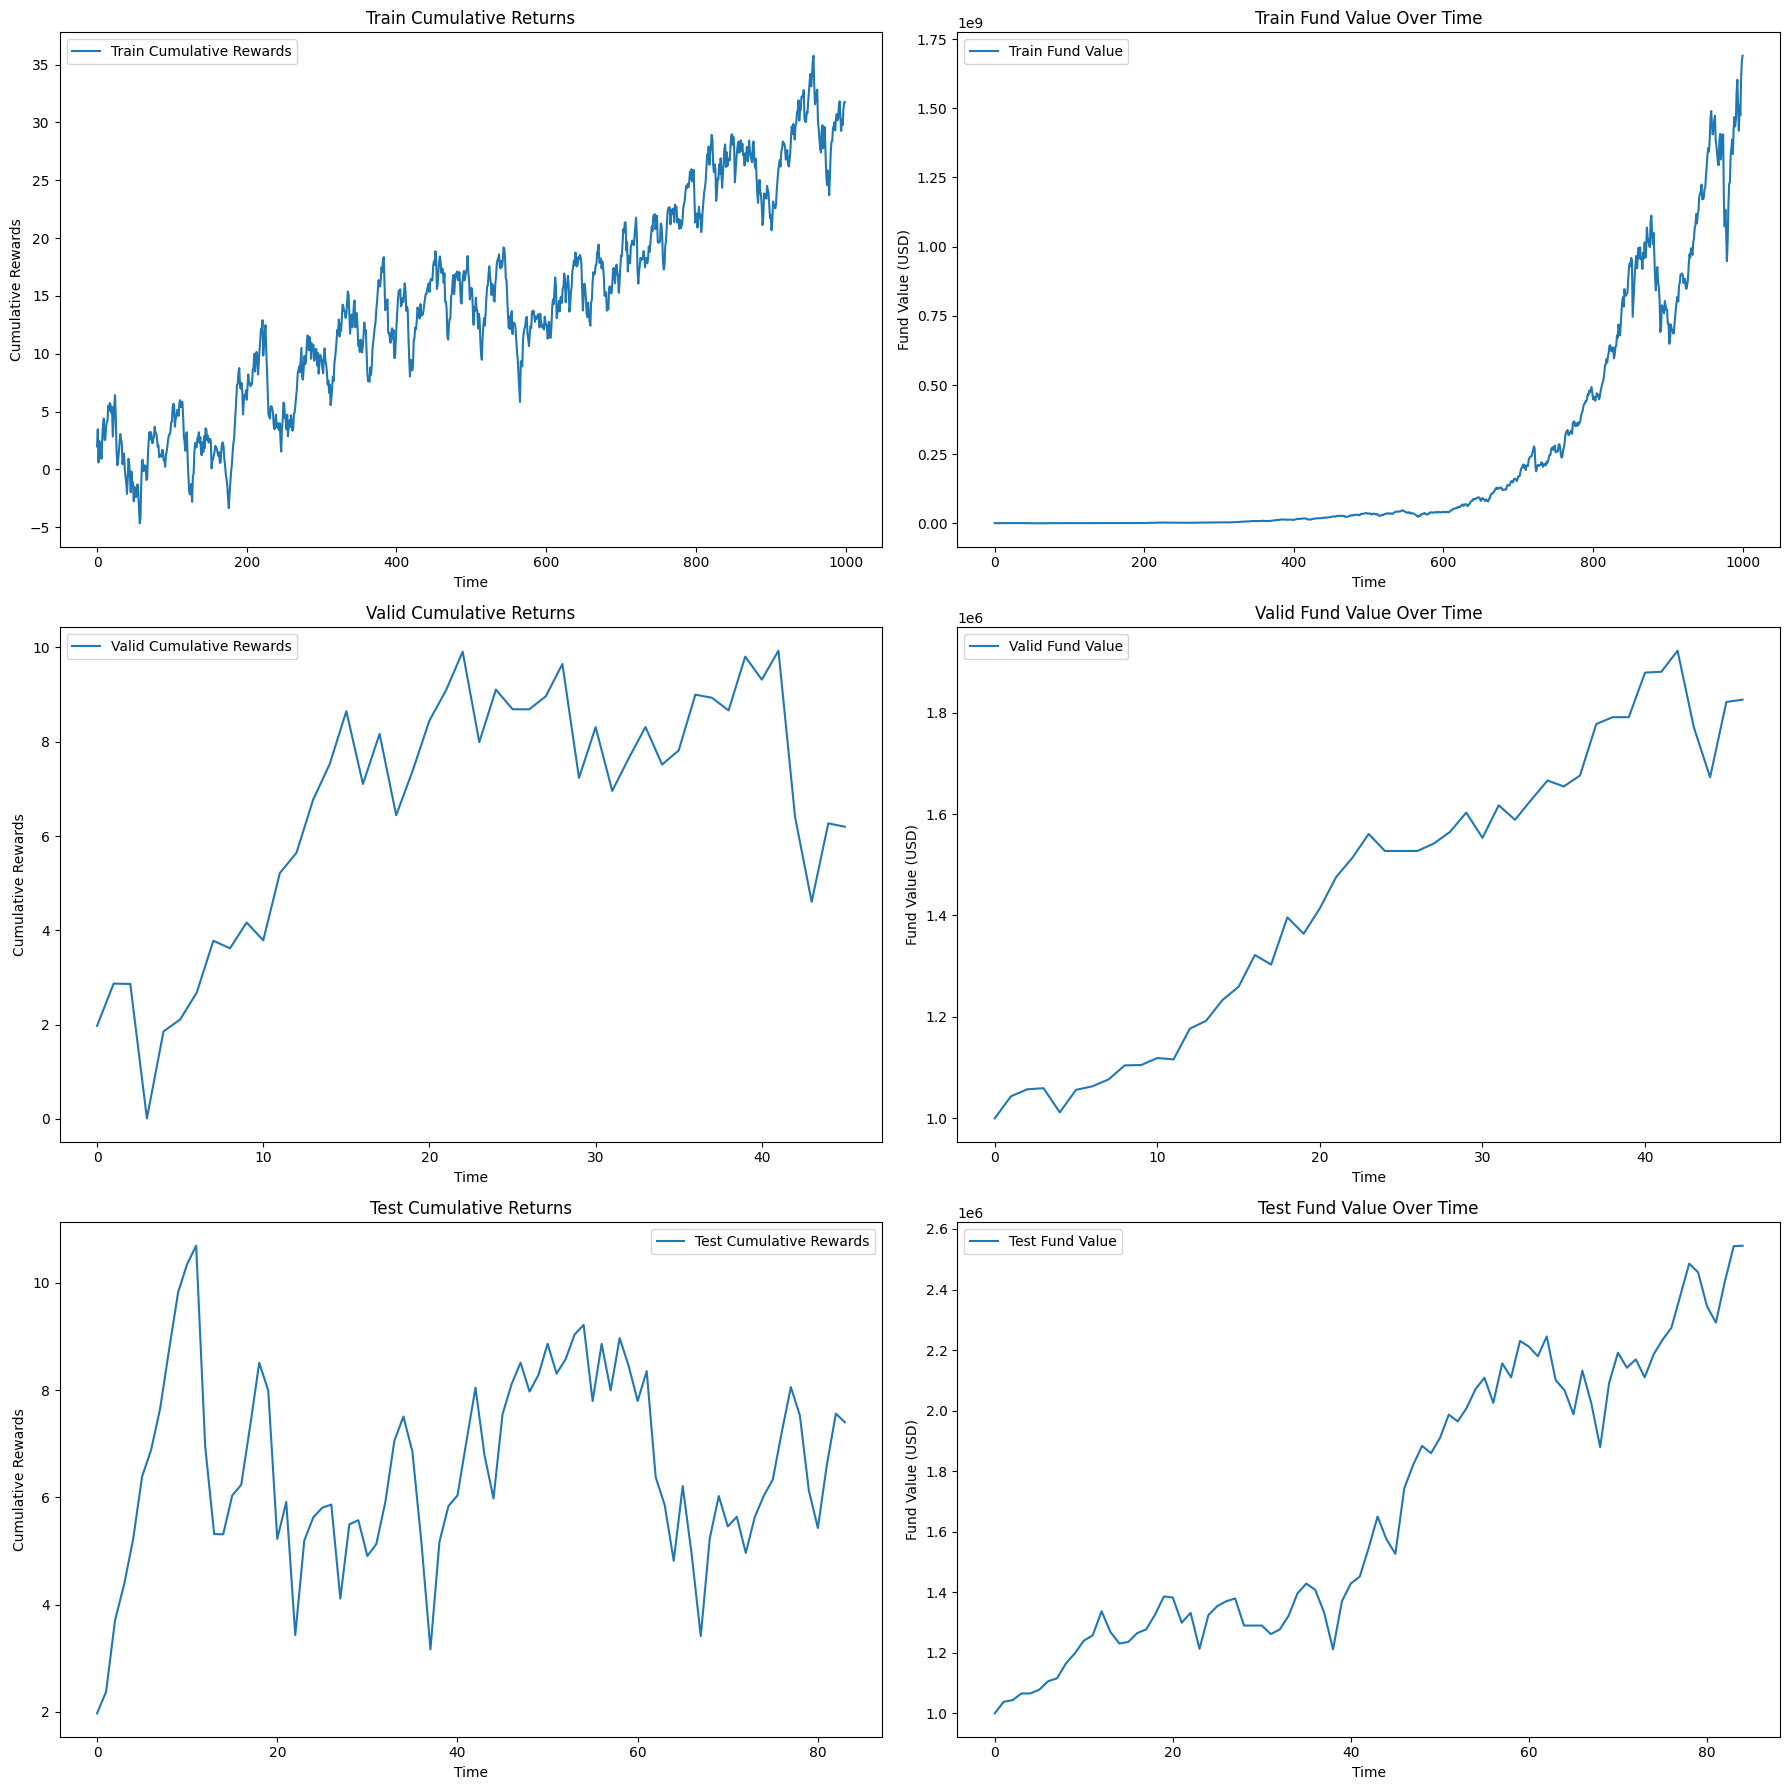

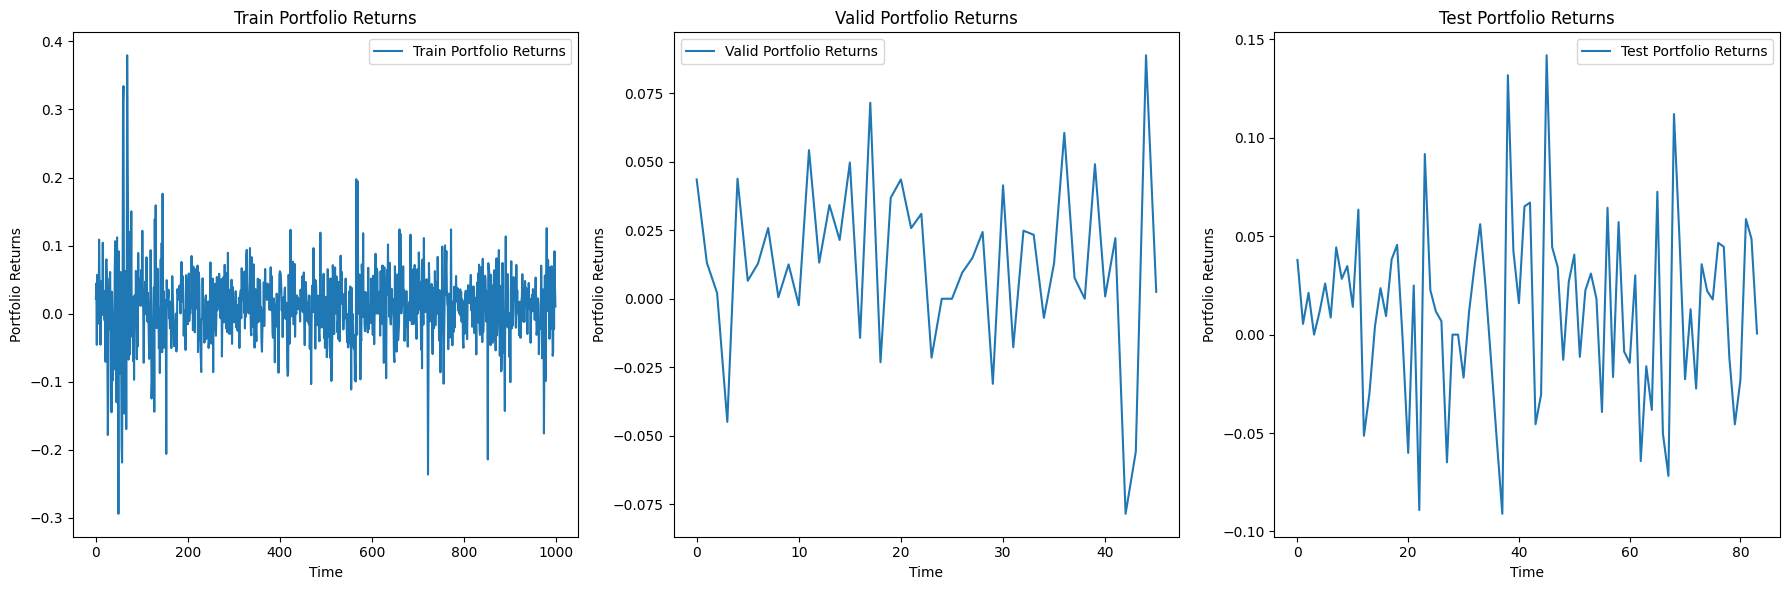

In [17]:
# Define a function to evaluate the model on a given environment
def evaluate_model(env, returns, initial_investment=1000000):
    current_fund = initial_investment
    obs = env.reset()
    cumulative_rewards = []
    fund_values = [current_fund]
    portfolio_returns = []

    for _ in range(len(returns) - env.envs[0].lookback_period):
        action, _states = model.predict(obs)

        # Normalize the action to make sure the weights sum to 1
        action_sum = np.sum(action)
        if action_sum != 0:
            action = action / action_sum

        obs, rewards, done, info = env.step(action)
        if done:
            break

        # Ensure portfolio_return is a scalar
        portfolio_return = np.dot(action, returns[env.envs[0].current_step])
        if isinstance(portfolio_return, np.ndarray):
            portfolio_return = portfolio_return.item()

        # Update the fund value based on the portfolio return
        current_fund *= (1 + portfolio_return)

        # Print the portfolio weights (action), portfolio return, reward, and fund value at each step
        print(f"Portfolio Weights: {action}, Portfolio Return: {portfolio_return}, Reward: {rewards}, Fund Value: {current_fund}")

        # Accumulate the portfolio returns, rewards, and fund values
        portfolio_returns.append(portfolio_return)
        cumulative_rewards.append(rewards)
        fund_values.append(current_fund)

    # Convert lists to numpy arrays for plotting
    cumulative_rewards = np.array(cumulative_rewards)
    fund_values = np.array(fund_values, dtype=np.float64)
    portfolio_returns = np.array(portfolio_returns, dtype=np.float64)

    return portfolio_returns, cumulative_rewards, fund_values

# Evaluate the model on the training set
print("Evaluating on Training Set")
train_portfolio_returns, train_cumulative_rewards, train_fund_values = evaluate_model(train_env, train_returns)

# Evaluate the model on the validation set
print("Evaluating on Validation Set")
valid_portfolio_returns, valid_cumulative_rewards, valid_fund_values = evaluate_model(valid_env, valid_returns)

# Evaluate the model on the test set
print("Evaluating on Test Set")
test_portfolio_returns, test_cumulative_rewards, test_fund_values = evaluate_model(test_env, test_returns)

# Plot the cumulative returns, fund values, and portfolio returns for training, validation, and test sets
plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
train_cumulative_returns = np.cumsum(train_cumulative_rewards)
plt.plot(train_cumulative_returns, label='Train Cumulative Rewards')
plt.title('Train Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Rewards')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_fund_values, label='Train Fund Value')
plt.title('Train Fund Value Over Time')
plt.xlabel('Time')
plt.ylabel('Fund Value (USD)')
plt.legend()

plt.subplot(3, 2, 3)
valid_cumulative_returns = np.cumsum(valid_cumulative_rewards)
plt.plot(valid_cumulative_returns, label='Valid Cumulative Rewards')
plt.title('Valid Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Rewards')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(valid_fund_values, label='Valid Fund Value')
plt.title('Valid Fund Value Over Time')
plt.xlabel('Time')
plt.ylabel('Fund Value (USD)')
plt.legend()

plt.subplot(3, 2, 5)
test_cumulative_returns = np.cumsum(test_cumulative_rewards)
plt.plot(test_cumulative_returns, label='Test Cumulative Rewards')
plt.title('Test Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Rewards')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(test_fund_values, label='Test Fund Value')
plt.title('Test Fund Value Over Time')
plt.xlabel('Time')
plt.ylabel('Fund Value (USD)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot portfolio returns for training, validation, and test sets
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(train_portfolio_returns, label='Train Portfolio Returns')
plt.title('Train Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(valid_portfolio_returns, label='Valid Portfolio Returns')
plt.title('Valid Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_portfolio_returns, label='Test Portfolio Returns')
plt.title('Test Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.legend()

plt.tight_layout()
plt.show()


To calculate the requested performance metrics for `test_portfolio_returns`, we need to implement the respective formulas. Below is the Explanation of the Calculations:


1. **Annual Return**:
   - $$ \text{Annual Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right)^{\frac{12}{n}} - 1 $$
   - Where $r_i$ are the monthly returns.


2. **Cumulative Returns**:
   - $$ \text{Cumulative Returns} = \prod_{i=1}^{n} (1 + r_i) - 1 $$


3. **Annual Volatility**:
   - $$ \text{Annual Volatility} = \text{std(monthly returns)} \times \sqrt{12} $$


4. **Sharpe Ratio**:
   - $$ \text{Sharpe Ratio} = \frac{\text{Annual Return} - \text{Risk-Free Rate}}{\text{Annual Volatility}} $$


5. **Maximum Drawdown**:
   - $$ \text{Max Drawdown} = \max\left(1 - \frac{\text{Cumulative}}{\text{Cumulative.cummax()}}\right) $$


6. **Calmar Ratio**:
   - $$ \text{Calmar Ratio} = \frac{\text{Annual Return}}{\text{Max Drawdown}} $$


7. **Omega Ratio**:
   - $$ \text{Omega Ratio} = \frac{\sum(\text{monthly returns} > \text{threshold})}{-\sum(\text{monthly returns} < \text{threshold})} $$


8. **Sortino Ratio**:
   - $$ \text{Sortino Ratio} = \frac{\text{Annual Return} - \text{Risk-Free Rate}}{\text{Downside Deviation}} $$


9. **Skewness**:
   - $$ \text{Skewness} = \text{skew(monthly returns)} $$


10. **Kurtosis**:
    - $$ \text{Kurtosis} = \text{kurtosis(monthly returns)} $$


11. **Tail Ratio**:
    - $$ \text{Tail Ratio} = \frac{\text{monthly returns.quantile}(0.95)}{\left|\text{monthly returns.quantile}(0.05)\right|} $$


12. **Daily Value at Risk (VaR)**:
    $$\text{VaR}_{95\%} = \text{percentile}\left(\frac{\text{monthly returns}}{n}, 5\%\right)$$

where $n$ is the number of trading days in a month ( $n = 21$).






In [18]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming test_portfolio_returns is the numpy array with monthly returns
# Convert monthly returns to a Pandas Series for easier handling
monthly_returns = pd.Series(test_portfolio_returns)

# Calculate annual return
annual_return = ((1 + monthly_returns).prod() ** (12 / len(monthly_returns)) - 1)

# Calculate cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod() - 1

# Calculate annual volatility
annual_volatility = monthly_returns.std() * np.sqrt(12)

# Calculate Sharpe ratio
risk_free_rate = 0.02  # Assume a risk-free rate of 2%
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

# Calculate maximum drawdown
cumulative = (1 + monthly_returns).cumprod()
drawdown = 1 - cumulative / cumulative.cummax()
max_drawdown = drawdown.max()

# Calculate Calmar ratio
calmar_ratio = annual_return / max_drawdown

# Calculate Omega ratio
threshold_return = 0
gain_threshold = monthly_returns[monthly_returns > threshold_return].sum()
loss_threshold = -monthly_returns[monthly_returns < threshold_return].sum()
omega_ratio = gain_threshold / loss_threshold

# Calculate Sortino ratio
downside_deviation = monthly_returns[monthly_returns < 0].std() * np.sqrt(12)
sortino_ratio = (annual_return - risk_free_rate) / downside_deviation

# Calculate skewness
returns_skewness = skew(monthly_returns)

# Calculate kurtosis
returns_kurtosis = kurtosis(monthly_returns)

# Calculate the tail ratio
tail_ratio = monthly_returns[monthly_returns > monthly_returns.quantile(0.95)].mean() / abs(monthly_returns[monthly_returns < monthly_returns.quantile(0.05)].mean())

# Calculate daily value at risk (VaR)
confidence_level = 0.05
var_95 = np.percentile(monthly_returns, 100 * confidence_level)

# Compile results into a DataFrame
performance_metrics = {
    "Annual Return": [annual_return],
    "Cumulative Returns": [cumulative_returns.iloc[-1]],
    "Annual Volatility": [annual_volatility],
    "Sharpe Ratio": [sharpe_ratio],
    "Calmar Ratio": [calmar_ratio],
    "Max Drawdown": [max_drawdown],
    "Omega Ratio": [omega_ratio],
    "Sortino Ratio": [sortino_ratio],
    "Skew": [returns_skewness],
    "Kurtosis": [returns_kurtosis],
    "Tail Ratio": [tail_ratio],
    "Daily Value at Risk (VaR 95%)": [var_95]
}

performance_df = pd.DataFrame(performance_metrics)



In [19]:
# Display the performance metrics table
performance_df

,Annual Return,Cumulative Returns,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown,Omega Ratio,Sortino Ratio,Skew,Kurtosis,Tail Ratio,Daily Value at Risk (VaR 95%)
0,0.142745,1.544748,0.155951,0.787075,0.876944,0.162775,1.988763,1.450701,0.130137,0.464209,1.443445,-0.063618


Using cpu device
Using cpu device
Using cpu device
Using cpu device
Training DDPG
Epoch 1/50, Train Reward: 33.80096083349781, Valid Reward: 3.700679190456867
Best model for DDPG saved
Epoch 2/50, Train Reward: 31.62808672315441, Valid Reward: 2.859075978398323
Epoch 3/50, Train Reward: 34.05059585656272, Valid Reward: 3.929882863536477
Best model for DDPG saved
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 57       |
|    time_elapsed    | 17       |
|    total_timesteps | 4043     |
| train/             |          |
|    actor_loss      | -10.1    |
|    critic_loss     | 0.375    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3042     |
---------------------------------
Epoch 4/50, Train Reward: 32.685622486591456, Valid Reward: 2.7795878425240517
Epoch 5/50, Train Reward: 33.618218768329825, Valid Reward: 3.9706371035426855
Best model for DDPG saved
Epoch 6/50, Train Reward: 34.26518106018193

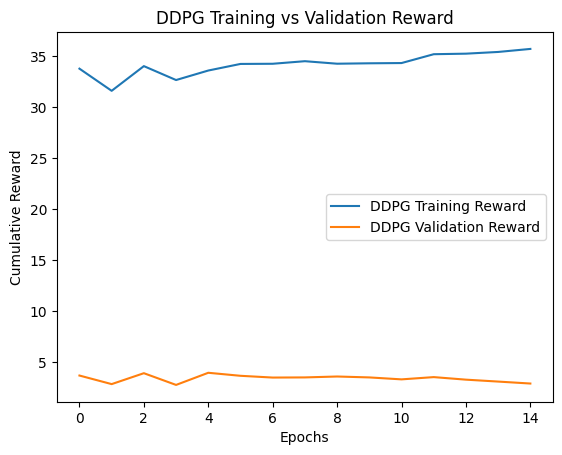

Training TD3
Epoch 1/50, Train Reward: 34.15059547133933, Valid Reward: 3.617191355675459
Best model for TD3 saved
Epoch 2/50, Train Reward: 26.76549446460922, Valid Reward: 5.594536552205682
Best model for TD3 saved
Epoch 3/50, Train Reward: 32.687411323189735, Valid Reward: 4.285508032888174
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 18       |
|    total_timesteps | 4043     |
| train/             |          |
|    actor_loss      | -1.91    |
|    critic_loss     | 0.539    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3042     |
---------------------------------
Epoch 4/50, Train Reward: 32.917661011684686, Valid Reward: 4.241647556424141
Epoch 5/50, Train Reward: 33.291717106476426, Valid Reward: 5.568153582513332
Epoch 6/50, Train Reward: 32.82431361790805, Valid Reward: 5.11804598197341
Epoch 7/50, Train Reward: 31.099323405651376, Valid Reward: 3.300

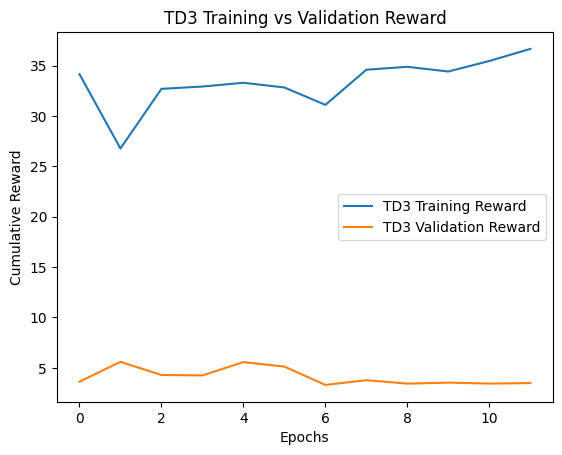

Training SAC
Epoch 1/50, Train Reward: 33.439145026379265, Valid Reward: 3.6651273630559444
Best model for SAC saved
Epoch 2/50, Train Reward: 32.387853951891884, Valid Reward: 4.08115603402257
Best model for SAC saved
Epoch 3/50, Train Reward: 34.337737928610295, Valid Reward: 4.066223410889506
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 50       |
|    time_elapsed    | 19       |
|    total_timesteps | 4043     |
| train/             |          |
|    actor_loss      | -28.9    |
|    critic_loss     | 0.902    |
|    ent_coef        | 0.403    |
|    ent_coef_loss   | -7.48    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3042     |
---------------------------------
Epoch 4/50, Train Reward: 33.654497910349164, Valid Reward: 5.180011130869389
Best model for SAC saved
Epoch 5/50, Train Reward: 33.96561856777407, Valid Reward: 3.2284197229892015
Epoch 6/50, Train Reward: 32.97792446985841, V

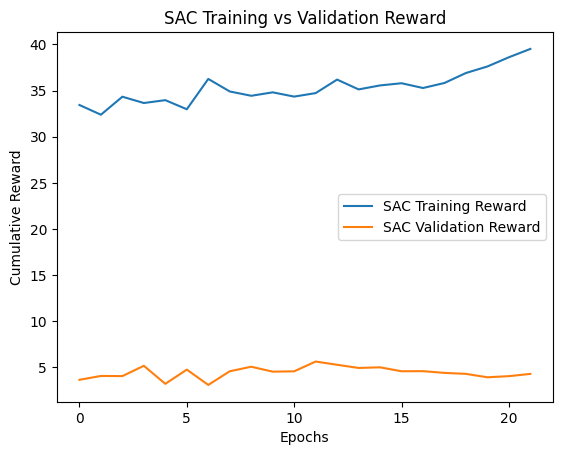

Training A2C
------------------------------------
| time/                 |          |
|    fps                | 637      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -7.08    |
|    explained_variance | 0.0639   |
|    learning_rate      | 0.0003   |
|    n_updates          | 99       |
|    policy_loss        | 5.13     |
|    std                | 0.998    |
|    value_loss         | 1.06     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 629      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -7.08    |
|    explained_variance | 0.226    |
|    learning_rate      | 0.0003   |
|    n_updates          | 199      |
|    policy_loss        |

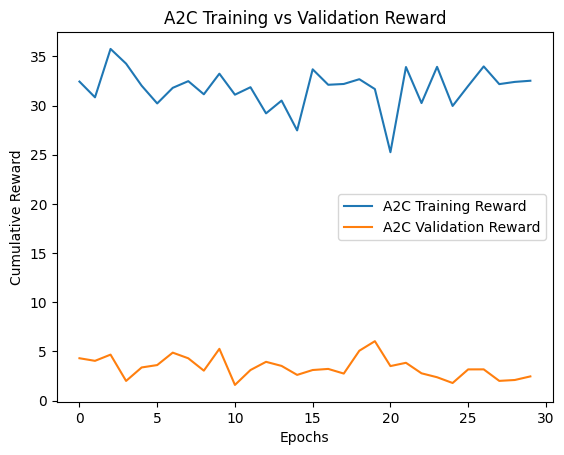

Evaluating DDPG
Portfolio Weights: [[0.33107603 0.1652238  0.1649765  0.16152537 0.17719828]], Portfolio Return: 0.037762994813919065, Reward: [1.9735287], Fund Value: 1037762.9948139191
Portfolio Weights: [[0.27432954 0.21315396 0.0979622  0.36537102 0.04918323]], Portfolio Return: 0.002941447531431914, Reward: [0.15021423], Fund Value: 1040815.520213226
Portfolio Weights: [[0.05774    0.34954527 0.24140015 0.27466348 0.07665116]], Portfolio Return: 0.009946578145772218, Reward: [0.8209732], Fund Value: 1051168.0731203593
Portfolio Weights: [[0.20880905 0.18547268 0.19323884 0.3228577  0.08962164]], Portfolio Return: 0.009567593659460546, Reward: [0.7827355], Fund Value: 1061225.222111773
Portfolio Weights: [[0.23239464 0.26978397 0.2573071  0.17596702 0.06454737]], Portfolio Return: 0.004952468495070934, Reward: [0.3383129], Fund Value: 1066480.9065904564
Portfolio Weights: [[0.20834488 0.30259278 0.16574603 0.29969108 0.02362527]], Portfolio Return: 0.015864145113527774, Reward: [1.

In [21]:
from stable_baselines3 import DDPG, TD3, SAC, A2C
from stable_baselines3.common.noise import NormalActionNoise

# Define hyperparameters
ddpg_hyperparams = {
    'learning_rate': 3e-4,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99
}

td3_hyperparams = {
    'learning_rate': 3e-4,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99
}

sac_hyperparams = {
    'learning_rate': 3e-4,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99
}

a2c_hyperparams = {
    'learning_rate': 3e-4,
    'n_steps': 5,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'ent_coef': 0.0,
    'vf_coef': 0.5,
    'max_grad_norm': 0.5
}

# Initialize the models
models = {
    'DDPG': DDPG('MlpPolicy', train_env, verbose=1, **ddpg_hyperparams),
    'TD3': TD3('MlpPolicy', train_env, verbose=1, **td3_hyperparams),
    'SAC': SAC('MlpPolicy', train_env, verbose=1, **sac_hyperparams),
    'A2C': A2C('MlpPolicy', train_env, verbose=1, **a2c_hyperparams)
}

# Train the models with early stopping
num_epochs = 50
patience = 10

for model_name, model in models.items():
    print(f"Training {model_name}")
    train_rewards = []
    valid_rewards = []
    best_valid_reward = -np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        model.learn(total_timesteps=1014, reset_num_timesteps=False)

        # Evaluate on training set
        obs = train_env.reset()
        train_cumulative_reward = 0
        while True:
            action, _states = model.predict(obs)
            obs, rewards, done, _ = train_env.step(action)
            train_cumulative_reward += rewards[0]
            if done:
                break
        train_rewards.append(train_cumulative_reward)

        # Evaluate on validation set
        obs = valid_env.reset()
        valid_cumulative_reward = 0
        while True:
            action, _states = model.predict(obs)
            obs, rewards, done, _ = valid_env.step(action)
            valid_cumulative_reward += rewards[0]
            if done:
                break
        valid_rewards.append(valid_cumulative_reward)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Reward: {train_cumulative_reward}, Valid Reward: {valid_cumulative_reward}")

        # Early stopping check
        if valid_cumulative_reward > best_valid_reward:
            best_valid_reward = valid_cumulative_reward
            patience_counter = 0
            # Save the best model
            model.save(f"best_model_{model_name}.zip")
            print(f"Best model for {model_name} saved")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered for {model_name}")
                break

    # Plot the training and validation rewards
    plt.plot(train_rewards, label=f'{model_name} Training Reward')
    plt.plot(valid_rewards, label=f'{model_name} Validation Reward')
    plt.xlabel('Epochs')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.title(f'{model_name} Training vs Validation Reward')
    plt.show()

# Load the best models for further use
best_models = {model_name: model.load(f"best_model_{model_name}.zip") for model_name, model in models.items()}

# Evaluate models and collect results
results = {}

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}")
    test_portfolio_returns, test_cumulative_rewards, test_fund_values = evaluate_model(test_env, test_returns, initial_investment=1000000)
    
    # Calculate performance metrics
    monthly_returns = pd.Series(test_portfolio_returns)
    annual_return = ((1 + monthly_returns).prod() ** (12 / len(monthly_returns)) - 1)
    cumulative_returns = (1 + monthly_returns).cumprod() - 1
    annual_volatility = monthly_returns.std() * np.sqrt(12)
    risk_free_rate = 0.02
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    cumulative = (1 + monthly_returns).cumprod()
    drawdown = 1 - cumulative / cumulative.cummax()
    max_drawdown = drawdown.max()
    calmar_ratio = annual_return / max_drawdown
    threshold_return = 0
    gain_threshold = monthly_returns[monthly_returns > threshold_return].sum()
    loss_threshold = -monthly_returns[monthly_returns < threshold_return].sum()
    omega_ratio = gain_threshold / loss_threshold
    downside_deviation = monthly_returns[monthly_returns < 0].std() * np.sqrt(12)
    sortino_ratio = (annual_return - risk_free_rate) / downside_deviation
    returns_skewness = skew(monthly_returns)
    returns_kurtosis = kurtosis(monthly_returns)
    tail_ratio = monthly_returns[monthly_returns > monthly_returns.quantile(0.95)].mean() / abs(monthly_returns[monthly_returns < monthly_returns.quantile(0.05)].mean())
    confidence_level = 0.05
    var_95 = np.percentile(monthly_returns, 100 * confidence_level)

    performance_metrics = {
        "Annual Return": annual_return,
        "Cumulative Returns": cumulative_returns.iloc[-1],
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Calmar Ratio": calmar_ratio,
        "Max Drawdown": max_drawdown,
        "Omega Ratio": omega_ratio,
        "Sortino Ratio": sortino_ratio,
        "Skew": returns_skewness,
        "Kurtosis": returns_kurtosis,
        "Tail Ratio": tail_ratio,
        "Daily Value at Risk (VaR 95%)": var_95
    }

    results[model_name] = performance_metrics

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

In [22]:
results_df

,Annual Return,Cumulative Returns,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown,Omega Ratio,Sortino Ratio,Skew,Kurtosis,Tail Ratio,Daily Value at Risk (VaR 95%)
DDPG,0.118057,1.183977,0.170832,0.573996,0.517353,0.228195,1.740523,0.812995,-0.473315,1.128776,1.037535,-0.078306
TD3,0.110213,1.078946,0.153066,0.589373,0.616918,0.178651,1.718362,1.037684,-0.026483,-0.188787,1.189570,-0.059122
SAC,0.133042,1.397296,0.164915,0.685456,0.686900,0.193684,1.862731,1.045235,-0.210436,0.335477,1.186474,-0.077158
A2C,0.129971,1.352179,0.165039,0.666331,0.569163,0.228354,1.828364,0.953546,-0.617793,0.622383,0.972197,-0.074740


In [23]:
performance_df.index = ['PPO']

# Combine performance_df with results_df
combined_results_df = pd.concat([performance_df, results_df])
combined_results_df

,Annual Return,Cumulative Returns,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown,Omega Ratio,Sortino Ratio,Skew,Kurtosis,Tail Ratio,Daily Value at Risk (VaR 95%)
PPO,0.142745,1.544748,0.155951,0.787075,0.876944,0.162775,1.988763,1.450701,0.130137,0.464209,1.443445,-0.063618
DDPG,0.118057,1.183977,0.170832,0.573996,0.517353,0.228195,1.740523,0.812995,-0.473315,1.128776,1.037535,-0.078306
TD3,0.110213,1.078946,0.153066,0.589373,0.616918,0.178651,1.718362,1.037684,-0.026483,-0.188787,1.189570,-0.059122
SAC,0.133042,1.397296,0.164915,0.685456,0.686900,0.193684,1.862731,1.045235,-0.210436,0.335477,1.186474,-0.077158
A2C,0.129971,1.352179,0.165039,0.666331,0.569163,0.228354,1.828364,0.953546,-0.617793,0.622383,0.972197,-0.074740


In [53]:
test_data

,Cnsmr,Manuf,HiTec,Hlth,Other
2016-01-01,-0.0330,-0.0336,-0.0485,-0.1013,-0.0877
2016-02-01,0.0052,0.0128,-0.0048,-0.0098,-0.0043
2016-03-01,0.0581,0.0815,0.0789,0.0396,0.0716
2016-04-01,-0.0015,0.0354,-0.0312,0.0495,0.0239
2016-05-01,0.0073,0.0001,0.0408,0.0241,0.0120
...,...,...,...,...,...
2023-10-01,-0.0343,-0.0305,-0.0168,-0.0458,-0.0253
2023-11-01,0.0788,0.0522,0.1165,0.0587,0.1041
2023-12-01,0.0548,0.0385,0.0456,0.0690,0.0654
2024-01-01,-0.0226,-0.0128,0.0313,0.0352,0.0104


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

# Assuming test_data is already loaded
# Calculate the portfolio returns by equally weighting each stock
portfolio_returns = test_data.mean(axis=1)

# Calculate performance metrics
# Convert monthly returns to a Pandas Series for easier handling
monthly_returns = pd.Series(portfolio_returns)

# Calculate annual return
annual_return_1_n = ((1 + monthly_returns).prod() ** (12 / len(monthly_returns)) - 1)

# Calculate cumulative returns
cumulative_returns_1_n = (1 + monthly_returns).cumprod() - 1

# Calculate annual volatility
annual_volatility_1_n = monthly_returns.std() * np.sqrt(12)

# Calculate Sharpe ratio
risk_free_rate = 0.02  # Assume a risk-free rate of 2%
sharpe_ratio_1_n = (annual_return_1_n - risk_free_rate) / annual_volatility_1_n

# Calculate maximum drawdown
cumulative = (1 + monthly_returns).cumprod()
drawdown = 1 - cumulative / cumulative.cummax()
max_drawdown_1_n = drawdown.max()

# Calculate Calmar ratio
calmar_ratio_1_n = annual_return_1_n / max_drawdown_1_n

# Calculate Omega ratio
threshold_return = 0
gain_threshold = monthly_returns[monthly_returns > threshold_return].sum()
loss_threshold = -monthly_returns[monthly_returns < threshold_return].sum()
omega_ratio_1_n = gain_threshold / loss_threshold

# Calculate Sortino ratio
downside_deviation = monthly_returns[monthly_returns < 0].std() * np.sqrt(12)
sortino_ratio_1_n = (annual_return_1_n - risk_free_rate) / downside_deviation

# Calculate skewness
skew_1_n = skew(monthly_returns)

# Calculate kurtosis
kurtosis_1_n = kurtosis(monthly_returns)

# Calculate tail ratio
tail_ratio = monthly_returns[monthly_returns > monthly_returns.quantile(0.95)].mean() / abs(monthly_returns[monthly_returns < monthly_returns.quantile(0.05)].mean())

# Calculate daily value at risk (VaR)
confidence_level = 0.05
var_95_1_n = np.percentile(monthly_returns, 100 * confidence_level)

# Compile results into a DataFrame
performance_metrics_equal = {
    "Annual Return": [annual_return_1_n],
    "Cumulative Returns": [cumulative_returns_1_n.iloc[-1]],
    "Annual Volatility": [annual_volatility_1_n],
    "Sharpe Ratio": [sharpe_ratio_1_n],
    "Calmar Ratio": [calmar_ratio_1_n],
    "Max Drawdown": [max_drawdown_1_n],
    "Omega Ratio": [omega_ratio_1_n],
    "Sortino Ratio": [sortino_ratio_1_n],
    "Skew": [skew_1_n],
    "Kurtosis": [kurtosis_1_n],
    "Tail Ratio": [tail_ratio_1_n],
    "Daily Value at Risk (VaR 95%)": [var_95_1_n]
}

performance_df_equal = pd.DataFrame(performance_metrics_equal, index=['Equal_Weight'])

# Display the performance metrics table
performance_df_equal


,Annual Return,Cumulative Returns,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown,Omega Ratio,Sortino Ratio,Skew,Kurtosis,Tail Ratio,Daily Value at Risk (VaR 95%)
Equal_Weight,0.13026,1.718261,0.159271,0.692281,0.623785,0.208823,1.881733,1.035312,-0.345441,0.609186,1.066113,-0.076732


In [25]:
# Combine performance_df with results_df
combined_results_df = pd.concat([combined_results_df, performance_df_equal])
combined_results_df

,Annual Return,Cumulative Returns,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown,Omega Ratio,Sortino Ratio,Skew,Kurtosis,Tail Ratio,Daily Value at Risk (VaR 95%)
PPO,0.142745,1.544748,0.155951,0.787075,0.876944,0.162775,1.988763,1.450701,0.130137,0.464209,1.443445,-0.063618
DDPG,0.118057,1.183977,0.170832,0.573996,0.517353,0.228195,1.740523,0.812995,-0.473315,1.128776,1.037535,-0.078306
TD3,0.110213,1.078946,0.153066,0.589373,0.616918,0.178651,1.718362,1.037684,-0.026483,-0.188787,1.189570,-0.059122
SAC,0.133042,1.397296,0.164915,0.685456,0.686900,0.193684,1.862731,1.045235,-0.210436,0.335477,1.186474,-0.077158
A2C,0.129971,1.352179,0.165039,0.666331,0.569163,0.228354,1.828364,0.953546,-0.617793,0.622383,0.972197,-0.074740
Equal_Weight,0.130260,1.718261,0.159271,0.692281,0.623785,0.208823,1.881733,1.035312,-0.345441,0.609186,1.066113,-0.076732


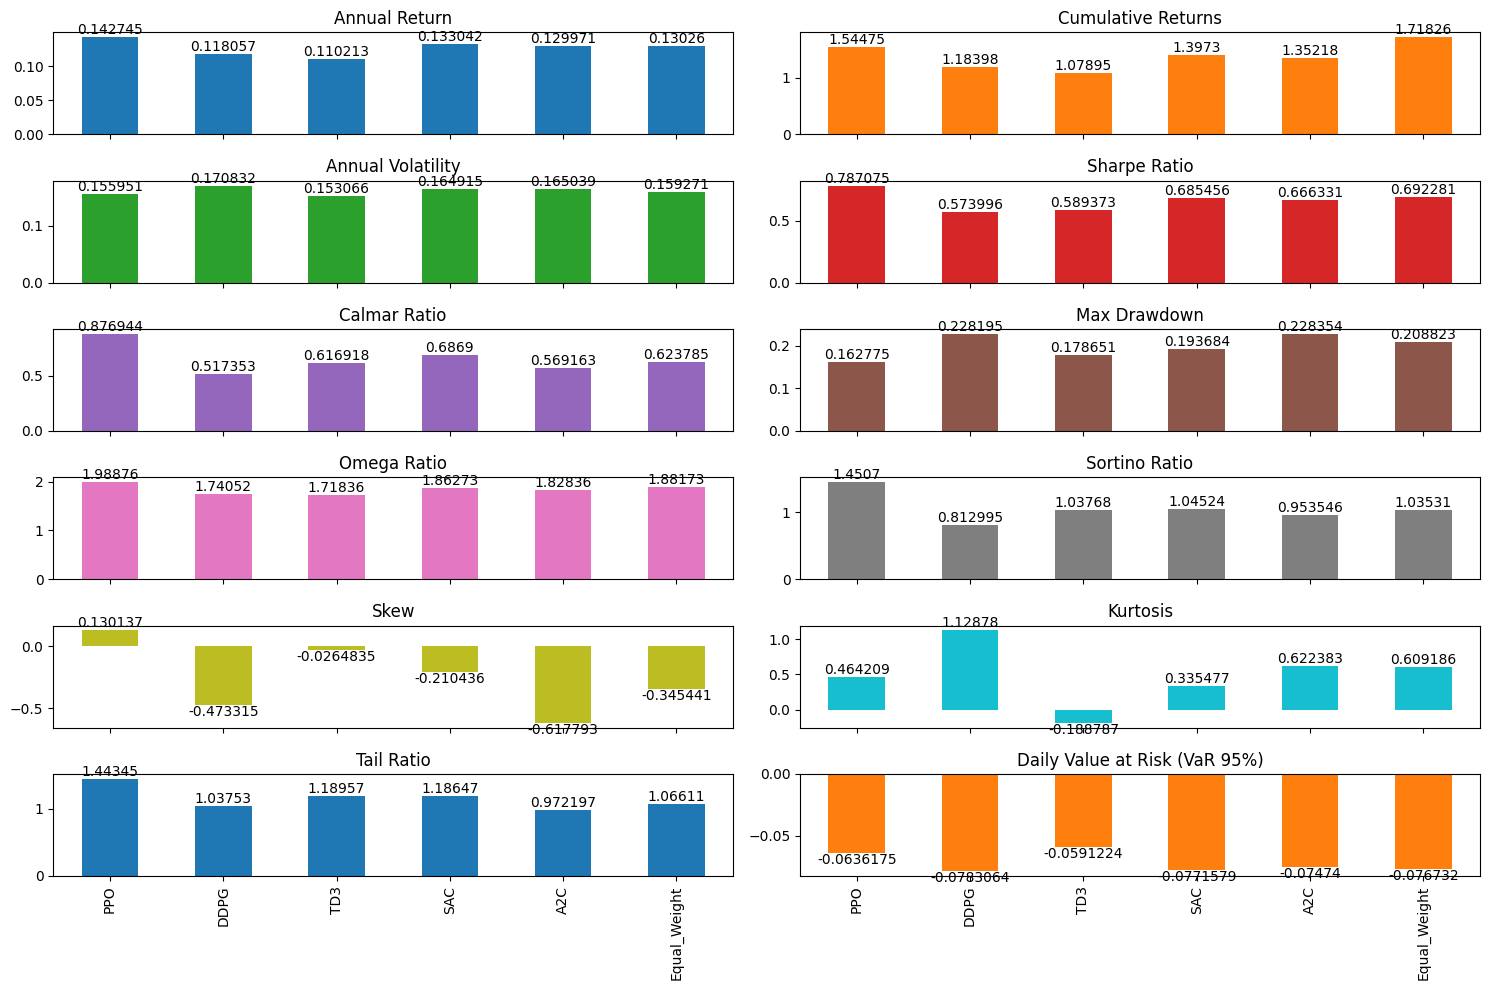

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming combined_results_df is already defined and contains your performance metrics

# Plot the performance metrics for comparison
axes = combined_results_df.plot(kind='bar', figsize=(15, 10), subplots=True, layout=(6, 2), legend=False)

# Annotate each bar with its value
for ax, col in zip(axes.flatten(), combined_results_df.columns):
    for container in ax.containers:
        ax.bar_label(container)

plt.tight_layout()
plt.show()


In [30]:
combined_results_df.to_csv('Result_for_RN.csv')

: 